<a href="https://colab.research.google.com/github/DorZaneti/Predicting_Fuel_Efficiency/blob/main/Predicting_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn

symbol = 'AAPL'
start_date = '2003-09-25'
end_date = '2023-09-25'

df = yf.download(symbol, start = start_date, end = end_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-09-25,0.381071,0.381607,0.361607,0.364821,0.309251,574380800
2003-09-26,0.362500,0.387500,0.359821,0.369464,0.313187,347250400
2003-09-29,0.383750,0.386964,0.368750,0.380357,0.322421,365702400
2003-09-30,0.376607,0.378929,0.365000,0.370000,0.313641,285426400
2003-10-01,0.369821,0.376786,0.360536,0.371250,0.314701,236112800
...,...,...,...,...,...,...
2023-09-18,176.479996,179.380005,176.169998,177.970001,177.735840,67257600
2023-09-19,177.520004,179.630005,177.130005,179.070007,178.834396,51826900
2023-09-20,179.259995,179.699997,175.399994,175.490005,175.259109,58436200


In [2]:
df = df[['Close']]
df_copy = df.reset_index()
df_copy

,Date,Close
0,2003-09-25,0.364821
1,2003-09-26,0.369464
2,2003-09-29,0.380357
3,2003-09-30,0.370000
4,2003-10-01,0.371250
...,...,...
5028,2023-09-18,177.970001
5029,2023-09-19,179.070007
5030,2023-09-20,175.490005
5031,2023-09-21,173.929993


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

Text(0, 0.5, 'Price')

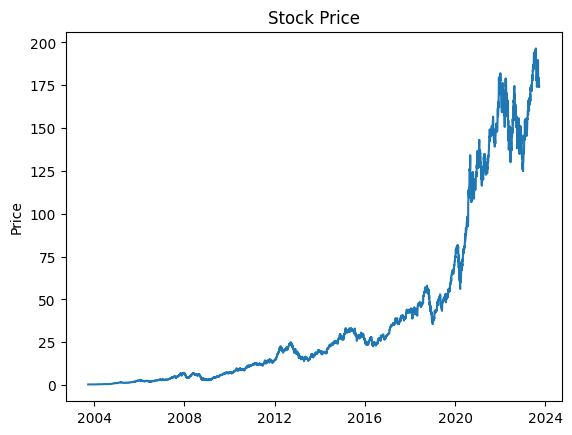

In [4]:
df_copy['Date'] = pd.to_datetime(df_copy['Date'])
plt.plot(df_copy['Date'], df_copy['Close'])
plt.title('Stock Price')
plt.ylabel('Price')

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df_copy, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2003-10-06,0.398036,0.387321,0.367321,0.371250,0.370000,0.380357,0.369464,0.364821
2003-10-07,0.414643,0.398036,0.387321,0.367321,0.371250,0.370000,0.380357,0.369464
2003-10-08,0.411786,0.414643,0.398036,0.387321,0.367321,0.371250,0.370000,0.380357
2003-10-09,0.418750,0.411786,0.414643,0.398036,0.387321,0.367321,0.371250,0.370000
2003-10-10,0.422857,0.418750,0.411786,0.414643,0.398036,0.387321,0.367321,0.371250
...,...,...,...,...,...,...,...,...
2023-09-18,177.970001,175.009995,175.740005,174.210007,176.300003,179.360001,178.179993,177.559998
2023-09-19,179.070007,177.970001,175.009995,175.740005,174.210007,176.300003,179.360001,178.179993
2023-09-20,175.490005,179.070007,177.970001,175.009995,175.740005,174.210007,176.300003,179.360001


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[  0.398036  ,   0.387321  ,   0.36732101, ...,   0.380357  ,
          0.36946401,   0.36482099],
       [  0.41464299,   0.398036  ,   0.387321  , ...,   0.37      ,
          0.380357  ,   0.36946401],
       [  0.41178599,   0.41464299,   0.398036  , ...,   0.37125   ,
          0.37      ,   0.380357  ],
       ...,
       [175.49000549, 179.07000732, 177.97000122, ..., 174.21000671,
        176.30000305, 179.36000061],
       [173.92999268, 175.49000549, 179.07000732, ..., 175.74000549,
        174.21000671, 176.30000305],
       [174.78999329, 173.92999268, 175.49000549, ..., 175.00999451,
        175.74000549, 174.21000671]])

In [7]:
shifted_df_as_np.shape

(5026, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.9995283 , -0.99963758, -0.99984156, ..., -0.99970861,
        -0.9998197 , -0.99986706],
       [-0.99935892, -0.9995283 , -0.99963758, ..., -0.99981424,
        -0.99970861, -0.9998197 ],
       [-0.99938806, -0.99935892, -0.9995283 , ..., -0.99980149,
        -0.99981424, -0.99970861],
       ...,
       [ 0.78622965,  0.82274199,  0.81152306, ...,  0.77317498,
         0.79449079,  0.82569962],
       [ 0.77031913,  0.78622965,  0.82274199, ...,  0.78877939,
         0.77317498,  0.79449079],
       [ 0.77909025,  0.77031913,  0.78622965, ...,  0.78133403,
         0.78877939,  0.77317498]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5026, 7), (5026,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99986706, -0.9998197 , -0.99970861, ..., -0.99980149,
        -0.99984156, -0.99963758],
       [-0.9998197 , -0.99970861, -0.99981424, ..., -0.99984156,
        -0.99963758, -0.9995283 ],
       [-0.99970861, -0.99981424, -0.99980149, ..., -0.99963758,
        -0.9995283 , -0.99935892],
       ...,
       [ 0.82569962,  0.79449079,  0.77317498, ...,  0.78133403,
         0.81152306,  0.82274199],
       [ 0.79449079,  0.77317498,  0.78877939, ...,  0.81152306,
         0.82274199,  0.78622965],
       [ 0.77317498,  0.78877939,  0.78133403, ...,  0.82274199,
         0.78622965,  0.77031913]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

4774

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4774, 7), (252, 7), (4774,), (252,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4774, 7, 1), (252, 7, 1), (4774, 1), (252, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4774, 7, 1]),
 torch.Size([252, 7, 1]),
 torch.Size([4774, 1]),
 torch.Size([252, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 7, 1]) torch.Size([32, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 5, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 5, num_layers=2, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.231

Val Loss: 1.279
***************************************************

Epoch: 2
Batch 100, Loss: 0.071

Val Loss: 0.210
***************************************************

Epoch: 3
Batch 100, Loss: 0.008

Val Loss: 0.064
***************************************************

Epoch: 4
Batch 100, Loss: 0.003

Val Loss: 0.035
***************************************************

Epoch: 5
Batch 100, Loss: 0.001

Val Loss: 0.018
***************************************************

Epoch: 6
Batch 100, Loss: 0.001

Val Loss: 0.012
***************************************************

Epoch: 7
Batch 100, Loss: 0.001

Val Loss: 0.010
***************************************************

Epoch: 8
Batch 100, Loss: 0.001

Val Loss: 0.008
***************************************************

Epoch: 9
Batch 100, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 10
Batch 100, Loss: 0.000

Val Loss: 0.006
********************************

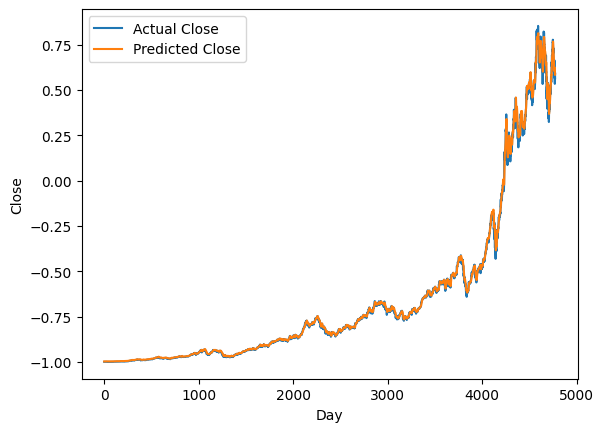

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.62110928,   0.62488462,   0.62996906, ..., 156.1791699 ,
       155.50754481, 156.02114322])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  0.39803684,   0.41464017,   0.41178821, ..., 154.47999733,
       156.89999132, 153.72000236])

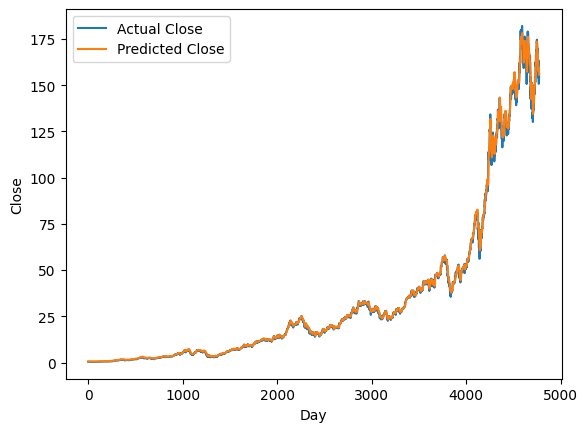

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [27]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([156.31618675, 156.17874328, 155.35978051, 154.43952637,
       153.87236019, 153.22378455, 151.06918655, 147.76520742,
       145.69943515, 145.38552076, 146.01206383, 146.77824779,
       146.15436382, 145.08154147, 143.6056751 , 142.20960519,
       142.35668572, 141.9987471 , 142.54511384, 143.52745072,
       144.48180566, 145.09471426, 146.33616464, 148.01919558,
       150.12736154, 151.28844858, 150.79475545, 152.180037  ,
       153.33872792, 153.68057166, 152.40652243, 149.30507928,
       145.92082446, 143.26896839, 141.88035566, 140.27661858,
       141.84404575, 144.74433216, 147.21462703, 149.41308561,
       150.65607301, 151.58840122, 152.23891713, 151.99714916,
       152.00671609, 152.2626036 , 151.90139809, 150.50064114,
       148.30366114, 147.85517861, 148.19258662, 148.79351464,
       149.15825589, 148.41979673, 146.85269099, 145.65608301,
       144.82795072, 144.95159024, 145.67319478, 145.94345313,
       144.35914212, 141.90728565, 139.10950619, 136.82

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([152.74000315, 150.42999082, 150.77000534, 151.75999226,
       149.83999726, 142.47999504, 138.19999659, 142.44999685,
       146.10000708, 146.3999948 , 145.42999206, 140.08999631,
       140.41999682, 138.9799962 , 138.33999689, 142.99000512,
       138.38000616, 142.41000511, 143.7500001 , 143.85999929,
       143.38999848, 147.27000357, 149.44999746, 152.33999811,
       149.3500035 , 144.80000384, 155.74000299, 153.33999611,
       150.64999506, 145.0299987 , 138.88000516, 138.38000616,
       138.9199969 , 139.49999983, 134.86999624, 146.86999561,
       149.69999404, 148.27999805, 150.03999102, 148.7899906 ,
       150.72000252, 151.28999144, 148.00999683, 150.17999425,
       151.07000474, 148.11000248, 144.22000091, 141.16999824,
       148.03000147, 148.30999623, 147.80999723, 146.63000427,
       142.91000411, 140.94000338, 142.64999353, 142.16000269,
       144.49000504, 145.47000133, 143.21000644, 136.49999999,
       134.50999462, 132.36999539, 132.30000255, 135.44

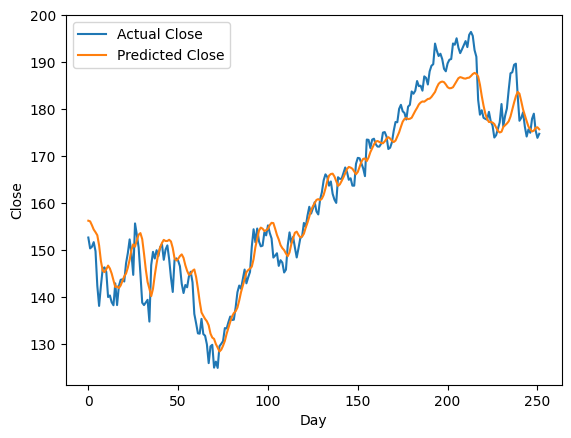

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
